# 实作cGAN演算法
### 程式修改自[Kaggle PyTorch Conditional GAN](https://www.kaggle.com/arturlacerda/pytorch-conditional-gan)

## 载入套件

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST

## 设定参数

In [2]:
BATCH_SIZE = 64  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 载入 FashionMNIST 资料

In [3]:
# 转换
transform=transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.5,), (0.5,)),
])

dataset = FashionMNIST('', train=True, download=True, 
                 transform=transform)
data_loader = torch.utils.data.DataLoader(dataset
                   , batch_size=BATCH_SIZE, shuffle=True)

In [4]:
dataset[0][0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

## 定义生成神经网路

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 设定嵌入层，作为 Label 的输入
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100) 
        c = self.label_emb(labels) 
        x = torch.cat([z, c], 1)  # 合并输入
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

## 定义判别神经网路

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 设定嵌入层，作为 Label 的输入
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)  # 合并输入
        out = self.model(x)
        return out.squeeze()

## 建立模型

In [7]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

## 设定损失函数、优化器(optimizer)

In [8]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

## 定义生成网路训练函数

In [9]:
def generator_train_step(batch_size, discriminator, generator, 
                         g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, 
                              batch_size))).to(device)   # 随机乱数 [1, 10]
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data.item()

## 定义判别网路训练函数

In [10]:
def discriminator_train_step(batch_size, discriminator, generator
                         , d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # 训练真实影像
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(
                batch_size)).to(device))
    
    # 训练伪造影像
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(
                0, 10, batch_size))).to(device)  # 随机乱数 [1, 10]
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(
                batch_size)).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.item()

## 训练

Starting epoch 0...
g_loss: 3.6246182918548584, d_loss: 0.1335843950510025


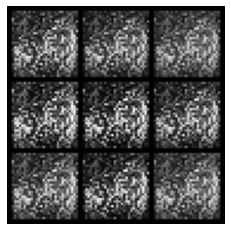

Starting epoch 1...
g_loss: 5.182674884796143, d_loss: 0.2211557775735855


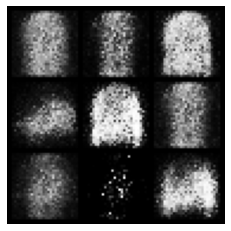

Starting epoch 2...
g_loss: 4.306463241577148, d_loss: 0.4896044135093689


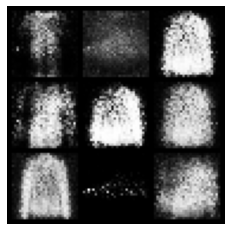

Starting epoch 3...
g_loss: 2.4511170387268066, d_loss: 0.5712658166885376


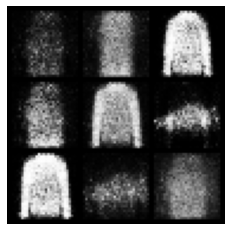

Starting epoch 4...
g_loss: 2.3960647583007812, d_loss: 0.6871167421340942


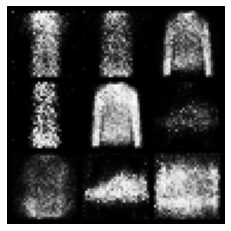

Starting epoch 5...
g_loss: 3.254668712615967, d_loss: 0.573541522026062


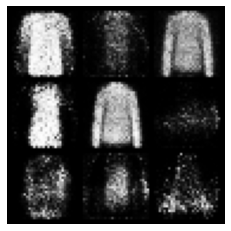

Starting epoch 6...
g_loss: 1.8158650398254395, d_loss: 0.8050476908683777


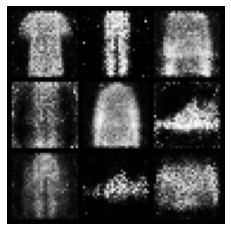

Starting epoch 7...
g_loss: 1.7099864482879639, d_loss: 1.1495994329452515


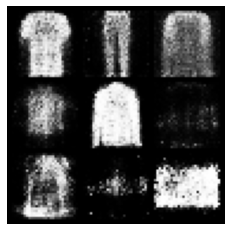

Starting epoch 8...
g_loss: 2.0553250312805176, d_loss: 0.8067918419837952


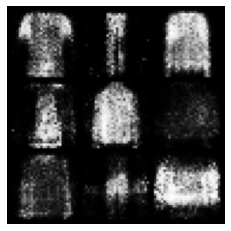

Starting epoch 9...
g_loss: 1.6429680585861206, d_loss: 0.8014601469039917


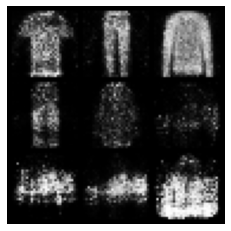

Starting epoch 10...
g_loss: 1.675607681274414, d_loss: 1.165052890777588


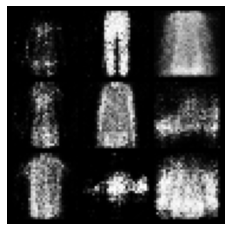

Starting epoch 11...
g_loss: 1.881744146347046, d_loss: 0.6710715293884277


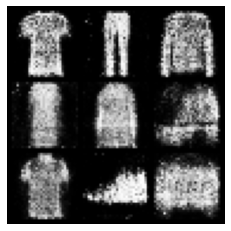

Starting epoch 12...
g_loss: 1.703579068183899, d_loss: 0.7614022493362427


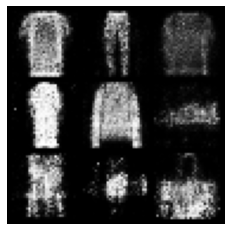

Starting epoch 13...
g_loss: 1.5942963361740112, d_loss: 0.8003547191619873


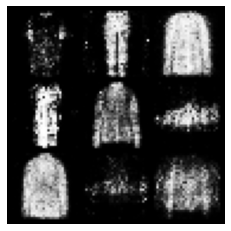

Starting epoch 14...
g_loss: 1.743251085281372, d_loss: 0.6059226989746094


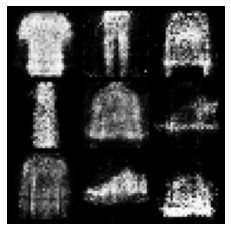

Starting epoch 15...
g_loss: 1.370608925819397, d_loss: 0.868141770362854


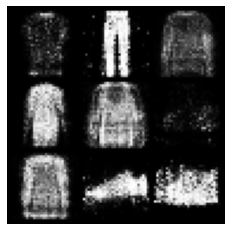

Starting epoch 16...
g_loss: 1.0664933919906616, d_loss: 0.9859635829925537


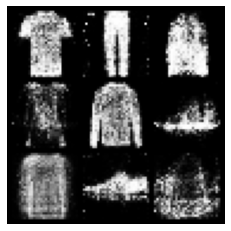

Starting epoch 17...
g_loss: 1.6444334983825684, d_loss: 0.8438751101493835


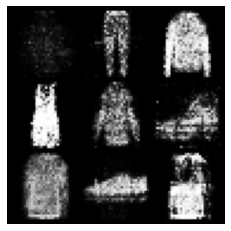

Starting epoch 18...
g_loss: 1.5665403604507446, d_loss: 1.13517427444458


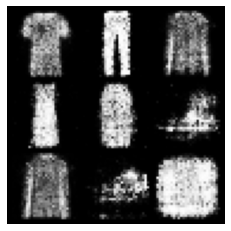

Starting epoch 19...
g_loss: 1.2825251817703247, d_loss: 0.8015700578689575


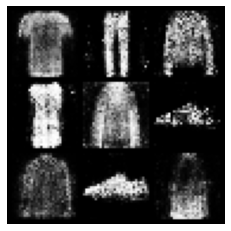

Starting epoch 20...
g_loss: 1.3446736335754395, d_loss: 0.8201001286506653


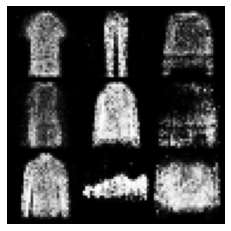

Starting epoch 21...
g_loss: 1.202627420425415, d_loss: 0.9602395296096802


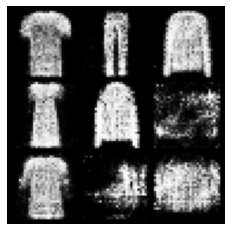

Starting epoch 22...
g_loss: 1.0888009071350098, d_loss: 1.2660512924194336


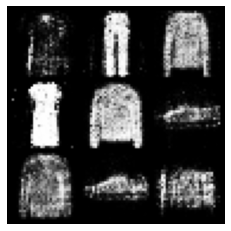

Starting epoch 23...
g_loss: 1.1322013139724731, d_loss: 1.1399726867675781


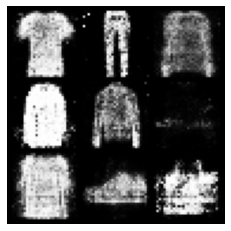

Starting epoch 24...
g_loss: 1.2693246603012085, d_loss: 1.2294540405273438


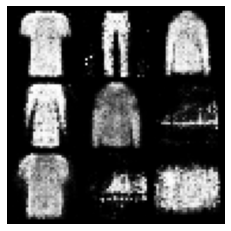

Starting epoch 25...
g_loss: 1.3319605588912964, d_loss: 0.90309739112854


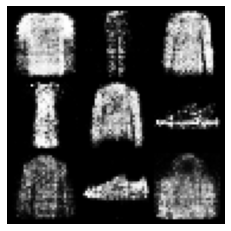

Starting epoch 26...
g_loss: 1.0699560642242432, d_loss: 1.2575186491012573


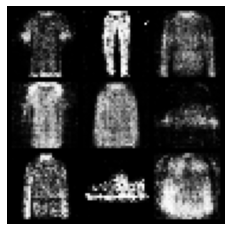

Starting epoch 27...
g_loss: 0.9995222091674805, d_loss: 1.1604493856430054


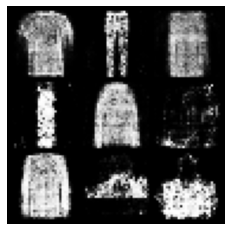

Starting epoch 28...
g_loss: 1.2451238632202148, d_loss: 1.0965917110443115


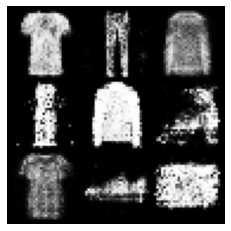

Starting epoch 29...
g_loss: 1.340527057647705, d_loss: 1.173032522201538


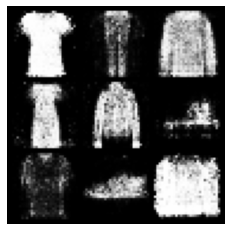

In [11]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, 
                                      generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).to(device)
    labels = Variable(torch.LongTensor(np.arange(9))).to(device)
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True)\
                .permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

## 生成新资料

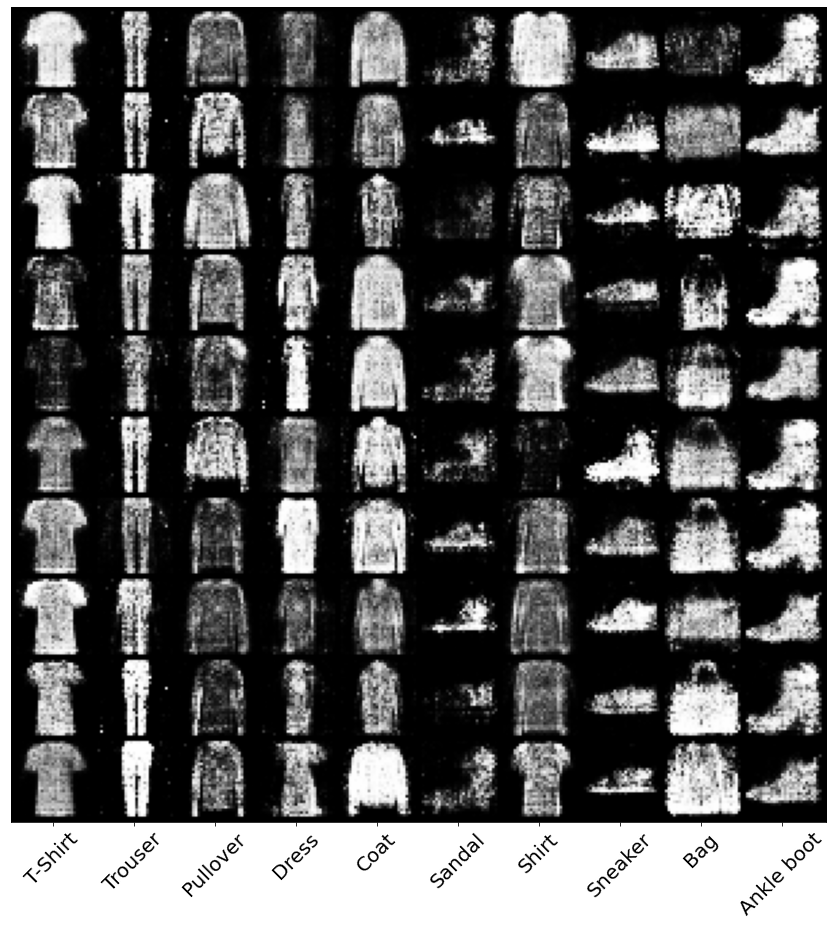

In [12]:
# 标注名称
label_names = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat'
               , 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
z = Variable(torch.randn(100, 100)).to(device)
labels = Variable(torch.LongTensor([i for _ in range(10) for i 
                                    in range(10)])).to(device)

# 生成图像
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True)\
                            .permute(1,2,0).numpy()

# 显示图像
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
plt.yticks([])
plt.xticks(np.arange(15, 300, 30), label_names, 
           rotation=45, fontsize=20);